# Studying phase angle differences in tips that annihilate
Tim Tyree<br>
5.11.2021

In [1]:
from lib.routines.return_reaction_ranges_from_folder import *
from lib.my_initialization import *
from lib import *
from lib.utils.merge_cloud_results import *
import seaborn as sns
# from scipy.interpolate import CubicSpline
from scipy.interpolate import splprep, splev
from lib.viewer.multicolored_lines import *
import matplotlib
%load_ext autoreload
%autoreload 2
# TODO: find when birth occurs for the tip of interest (HINT: look at the video!!!)
# TODO: make a video where activation fronts are highlighted by curvature!

# Do tips that annihilate synch up in phase just before death? 
are they significantly directed away from one another?

In [2]:
# def compute_phase_angles_from_grad_voltage(d1,d2):
#     #compute the displacement vector between these spiral tips
#     d1['x2']=d2['x']
#     d1['y2']=d2['y']
#     d1['dx']=d1['x2']-d1['x']
#     d1['dy']=d1['y2']-d1['y']
#     d1['range']=np.sqrt(d1['dx']**2+d1['dy']**2)
#     d1['dxhat']=d1['dx']/d1['range']
#     d1['dyhat']=d1['dy']/d1['range']
#     d2['dxhat']=d1['dxhat']
#     d2['dyhat']=d1['dyhat']
#     d1['grad_u_mag']=np.sqrt(d1['grad_ux']**2+d1['grad_uy']**2)
#     d2['grad_u_mag']=np.sqrt(d2['grad_ux']**2+d2['grad_uy']**2)
    
# #     #cosine method is equivalent up to sign
# #     # - using cross product of dx,y_hat with +-ahat
# #     #TODO: - using  dot  product of dx,y_hat with +,-grad_u
# #     #compute the min/max absolute phase angles 
# #     cosine_values=(d1['dxhat']*d1['grad_ux']+d1['dyhat']*d1['grad_uy'])/d1['grad_u_mag']
# #     d1['phi1']=np.arcsin(cosine_values)
# #     cosine_values=(d2['dxhat']*d2['grad_ux']+d2['dyhat']*d2['grad_uy'])/d2['grad_u_mag']
# #     d2['phi2']=np.arcsin(cosine_values)
# #     boo=~d1.phi1.isnull()
# #     t1_values=d1[boo]['t'].values
# #     boo=~d2.phi2.isnull()
# #     t2_values=d2[boo]['t'].values

#     d1['a1x']=d1['grad_uy']/d1['grad_u_mag']
#     d1['a1y']=-d1['grad_ux']/d1['grad_u_mag']
#     sine_values_left=d1['a1x']*d1['dyhat']-d1['a1y']*d1['dxhat']
#     sine_values_right=-d1['a1x']*d1['dyhat']+d1['a1y']*d1['dxhat']

#     if np.arcsin(sine_values_left).values[-1]>0:
#         # choose self-consistent convention that ends in giving phi a positive phase value
#         d1['phi1']=np.arcsin(sine_values_left)
#     else:
#         d1['phi1']=np.arcsin(sine_values_right)

#     d2['ax']=d2['grad_uy']/d2['grad_u_mag']
#     d2['ay']=-d2['grad_ux']/d2['grad_u_mag']
#     sine_values_left=d2['ax']*d2['dyhat']-d2['ay']*d2['dxhat']
#     sine_values_right=-d2['ax']*d2['dyhat']+d2['ay']*d2['dxhat']

#     if np.arcsin(sine_values_left).values[-1]<0:
#         # choose self-consistent convention that ends in giving phi a negative phase value
#         d2['phi2']=np.arcsin(sine_values_left)
#     else:
#         d2['phi2']=np.arcsin(sine_values_right)

#     boo=~d1.phi1.isnull()
#     t1_values=d1[boo]['t'].values
#     x_values=t1_values[-1]-t1_values
#     phi1_values=d1[boo]['phi1'].values

#     boo=~d2.phi2.isnull()
#     t2_values=d2[boo]['t'].values
#     phi2_values=d2[boo]['phi2'].values

#     phi_sum_values=phi1_values+phi2_values
#     phi_diff_values=phi1_values-phi2_values
#     t_to_death_values=x_values
#     return t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values

In [215]:
#Token fk model
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-300x300/ds_7.5_param_set_8/Log/ic300x300.0.6_traj_sr_600_mem_0.csv"
#Token lr model
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/param_qu_tmax_30/trajectories/ic300x300.3.3_traj_sr_600_mem_0.csv"
DS=5/200

# input_fn=search_for_file()
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.3_traj_sr_400_mem_0.csv"
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)

0.4


In [216]:
# death_ranges,birth_ranges,DT=return_bd_ranges(input_fn,DS,round_t_to_n_digits=3)
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

In [191]:
# from inspect import getsource
# print(getsource(compute_df_interactions))

In [217]:
#filter any deaths that occur at ranges exceeding 1 cm
range_threshold=1.#cm
boo=df_interactions.rT*DS<range_threshold
df_ordered_interactions=df_interactions[boo].sort_values('Tavg',ascending=False)

In [218]:
#for the first pid and its mate,
pid,pid_deathmate=df_ordered_interactions.head(1)[['pid','pid_deathmate']].values[0]
#extract their trajectories/particle dataframes
d1=df[df.particle==pid].copy()
d2=df[df.particle==pid_deathmate].copy()
d1.index=d1.frame
d2.index=d2.frame
#compute the phase time series between pid and pid_deathmate

#find last zero for when phi1==0

#compute phi2 at that time using linear interpolation

#append phi2 to dphi_lst... proceed to the next particle

In [194]:
#TODO: compute a1 using grad_ux and grad_uy


$$
\text{Let   } \phi_1\equiv\cos^{-1}\big(\widehat{\mathbf{x}_2-\mathbf{x}_1}\;\cdot\;\hat{\mathbf{a}}_1\big),
$$

$$
\text{and let   } \phi_2\equiv\cos^{-1}\big(\widehat{\mathbf{x}_1-\mathbf{x}_2}\;\cdot\;\hat{\mathbf{a}}_2\big).
$$

denote the (unsigned) phases of particle 1 & 2, where $\mathbf{a}_1$ and $\mathbf{a}_2$ are perpendicular to $\nabla V\equiv$ (grad_ux,grad_uy).

In [195]:
# grad_ux1_values=d1.grad_ux.values
# grad_uy1_values=d1.grad_uy.values
# x1_values=d1.x.values
# y1_values=d1.y.values

# a1_left_values=
# a1_right_values=

In [196]:
# xy1_values=np.array(list(zip(d1['x'],d1['y'])))
# xy2_values=np.array(list(zip(d2['x'],d2['y'])))
# xy2_minus_xy1_values=xy2_values-xy1_values
# range_values=np.linalg.norm(xy2_minus_xy1_values, axis=1)
# x2_minus_x1_hat_values=xy2_minus_xy1_values[:,0]/range_values
# y2_minus_y1_hat_values=xy2_minus_xy1_values[:,1]/range_values
# xy2_minus_xy1_hat_values=np.array(list(zip(x2_minus_x1_hat_values,y2_minus_y1_hat_values)))


In [219]:
t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values=compute_phase_angles_from_grad_voltage(d1,d2)
x_values=t_to_death_values

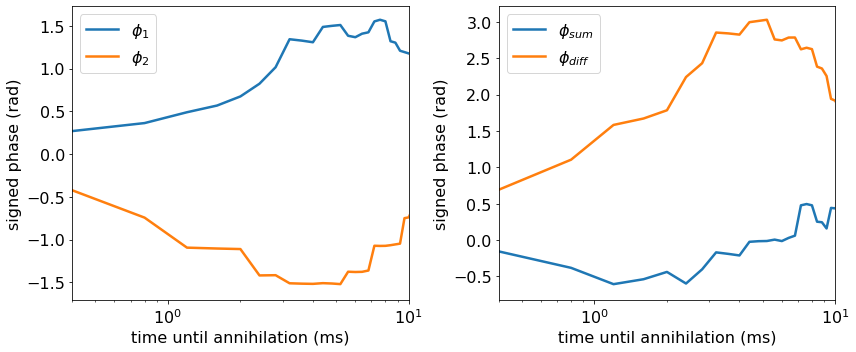

In [220]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values,y_values,alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

    ax.set_xlim([DT,1e1])
#     ax.set_ylim([-np.pi/8,np.pi/8])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

# compute mean phase angle difference near death

In [183]:
#TODO: compute crossing of zero
#TODO: does phi_sum always cross zero here?

In [221]:
#TODO: plot all trajectories in the pid_lst
pid_queue=list(df_ordered_interactions.pid.values)
pid_deathmate_dict=dict(zip(pid_queue,list(df_ordered_interactions.pid_deathmate.values)))
df_out_lst=[]
while len(pid_queue)>0:
    pid=pid_queue.pop(0)
    pid_deathmate=pid_deathmate_dict[pid]
    try:
        pid_queue.remove(pid_deathmate)
        #extract d1,d2
        d1=df[df.particle==pid].copy()
        d2=df[df.particle==pid_deathmate].copy()
        d1.index=d1.frame
        d2.index=d2.frame
        #compute x,y values
        t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values=compute_phase_angles_from_grad_voltage(d1,d2)
        x_values=t_to_death_values
        df_out=pd.DataFrame({
            'tdeath':t_to_death_values,
            'phi1':np.abs(phi1_values),
            'phi2':np.abs(phi2_values),
            'phi_sum':np.abs(phi_sum_values),
            'phi_diff':np.abs(phi_diff_values),
            'pid':pid
        })
        #append x,y values to list
        df_out_lst.append(df_out)
    except ValueError as e:
        pass

In [222]:
df_phases=pd.concat(df_out_lst)
# df_phases.head()

In [223]:
#TODO: plot xy values for pid in list
#TODO: compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tdeath').mean()
x_values=dfm.index.values
y_values=dfm.phi_diff.values
# plt.plot(x_values,y_values)

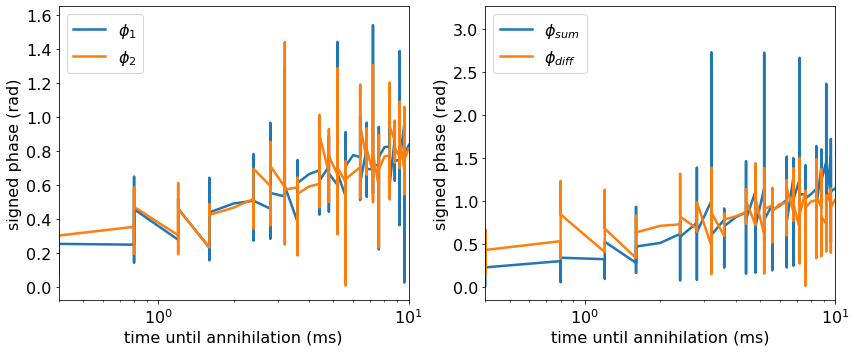

In [224]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

y_values_lst=[dfm.phi1.values,dfm.phi2.values,dfm.phi_sum.values, dfm.phi_diff.values]
# y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values,y_values,alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

    ax.set_xlim([DT,1e1])
#     ax.set_ylim([-np.pi/8,np.pi/8])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

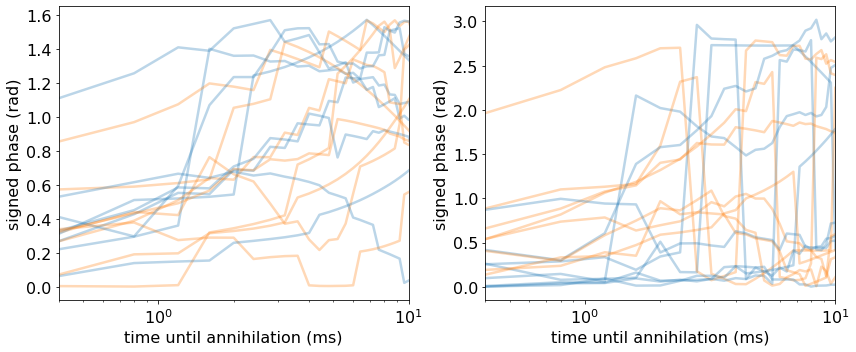

In [225]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

# y_values_lst=[dfm.phi1.values,dfm.phi2.values,dfm.phi_sum.values, dfm.phi_diff.values]
# y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

#extract local particle values
pid_lst=list(set(df_phases.pid.values))
for pid in pid_lst[:10]:
# pid=pid_lst[0]
    boo=df_phases.pid==pid
    y_values_lst=[df_phases[boo].phi1.values,df_phases[boo].phi2.values,df_phases[boo].phi_sum.values, df_phases[boo].phi_diff.values]
    x_values=df_phases[boo].tdeath.values
    for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
        ax=axs[nax]
        ax.plot(x_values,y_values,alpha=.3,label='_Hidden',c=color,lw=2.5)
        # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
        ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
        ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

        ax.set_xlim([DT,1e1])
    #     ax.set_ylim([-np.pi/8,np.pi/8])
        #     ax.set_xlim([1e-3,1e2])
        ax.set_xscale('log')
        # plt.yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=1)
    #     ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

## TODO(later): take more data for DT=0.01 or DT=0.001 ms.
- HINT: use the 2 step method for accurately determining the position of valid spiral tips
- HINT: use the active contour method to avoid the sign issue at the expense of run time
- HINT: only do ~100 cpu's for ~20 hours for the LR model
## TODO(later): replot phases... values should line up better

# TODO: measure histogram of the angles between initial velocities at birth

In [233]:
#TODO: compute crossing of zero
#TODO: does phi_sum always cross zero here?

In [234]:
# - TODO: measure the initial velocities of spiral tips at birth


# compute mean angle between initial velocities near birth

In [294]:
# def compute_angle_between_initial_velocities(d1,d2):
#     '''computes angle between initial velocities near birth for one tip pair.
#     Updates d1,d2 with fields.
#     Example Usage:
#     tbirth_values,angle_between_values=compute_angle_between_initial_velocities(d1,d2)
#     '''
#     d1[['dx','dy','dt']]=d1[['x','y','t']].diff().shift(-1).iloc[1:-1]
#     d1['displacement']=np.sqrt(d1['dx']**2+d1['dy']**2)
#     d1['dx_hat']=d1['dx']/d1['displacement']
#     d1['dy_hat']=d1['dy']/d1['displacement']

#     d2[['dx','dy','dt']]=d2[['x','y','t']].diff().shift(-1).iloc[1:-1]
#     d2['displacement']=np.sqrt(d2['dx']**2+d2['dy']**2)
#     d2['dx_hat']=d2['dx']/d2['displacement']
#     d2['dy_hat']=d2['dy']/d2['displacement']

#     cosine_series=d1['dx_hat']*d2['dx_hat']+d1['dy_hat']*d2['dy_hat']
#     d1['angle_between']=np.arccos(cosine_series)   #radians
#     angle_between_values=d1['angle_between'].values 
#     tbirth_values=d1['t'].values-d1['t'].values[0] #ms
#     return tbirth_values,angle_between_values

In [295]:
#DONE: compute angle between initial velocities near birth for one tip pair

In [2]:
pid_lst=df_ordered_interactions.pid.values
pid_mate_lst=df_ordered_interactions.pid_birthmate.values
pid_mate_dict=dict(zip(pid_lst,pid_mate_lst))

NameError: name 'df_ordered_interactions' is not defined

In [3]:
pid=pid_lst[0]
pid_mate=pid_mate_dict[pid]


NameError: name 'pid_lst' is not defined

In [298]:
#extract d1,d2
d1=df[df.particle==pid].copy()
d2=df[df.particle==pid_mate].copy()
d1.index=d1.frame
d2.index=d2.frame

tbirth_values,angle_between_values=compute_angle_between_initial_velocities(d1,d2)
df_out=pd.DataFrame({
    'tdeath':tbirth_values,
    'theta':angle_between_values,
    'pid':pid})

In [312]:
#TODO: augment df_out with ^that 
pid_queue=list(df_ordered_interactions.pid.values)
len(pid_queue)

423

In [313]:
#TODO: all trajectories in the pid_lst
pid_queue=list(df_ordered_interactions.pid.values)
df_out_lst=[]
while len(pid_queue)>0:
    pid=pid_queue.pop(0)
    pid_mate=pid_mate_dict[pid]
    try:
        pid_queue.remove(pid_mate)
        #extract d1,d2
        d1=df[df.particle==pid].copy()
        d2=df[df.particle==pid_mate].copy()
        d1.index=d1.frame
        d2.index=d2.frame

        tbirth_values,angle_between_values=compute_angle_between_initial_velocities(d1,d2)
        df_out=pd.DataFrame({
            'tau':tbirth_values,
            'theta':angle_between_values,
            'pid':pid})
        #append x,y values to list
        df_out_lst.append(df_out)
    except ValueError as e:
        pass

df_births=pd.concat(df_out_lst)
df_births.dropna(inplace=True)

plotting averages


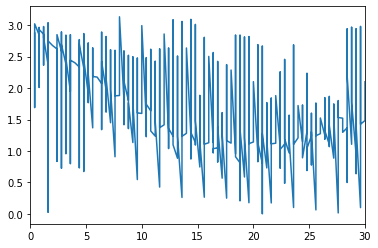

In [314]:
#TODO: plot xy values for pid in list
#TODO: compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_births.groupby('tau').mean()
x_values=dfm.index.values
y_values=dfm.theta.values
plt.plot(x_values,y_values)
plt.xlim([0,30])
print("plotting averages")
plt.show()

(0.4, 30.0)

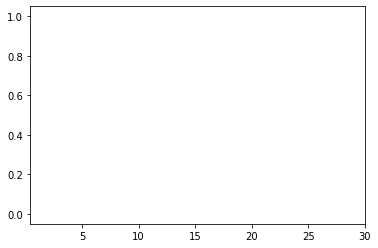

In [315]:
plt.plot(tbirth_values,angle_between_values)
plt.xlim([DT,3e1])

saved figure in 
	angles-between-births.png


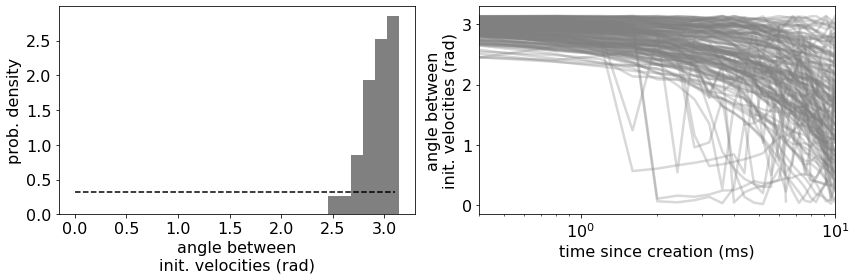

In [376]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,4))

# y_values_lst=[dfm.phi1.values,dfm.phi2.values,dfm.phi_sum.values, dfm.phi_diff.values]
# y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\vartheta$']
ax_lst=[1]
c_lst=['gray']
angle_threshold=2.3
init_val_lst=[]
#extract local particle values
pid_lst=list(set(df_births.pid.values))
for pid in pid_lst:#[:10]:
# pid=pid_lst[0]
    boo=df_births.pid==pid
    y_values_lst=[df_births[boo].theta.values]
    x_values=df_births[boo].tau.values
    for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
#         if (y_values[0]>=angle_threshold) or (y_values[1]>=angle_threshold):
        if not (y_values[:3]<angle_threshold).any():# or (y_values[1]>=angle_threshold):
            ax=axs[nax]
            ax.plot(x_values,y_values,alpha=.3,label='_Hidden',c=color,lw=2.5)
            # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
            ax.set_xlabel('time since creation (ms)',fontsize=fontsize)
#             ax.set_ylabel(r'$\vartheta$ (rad)',fontsize=fontsize)
            ax.set_ylabel('angle between\ninit. velocities (rad)',fontsize=fontsize)

            ax.set_xlim([DT,1e1])
        #     ax.set_ylim([-np.pi/8,np.pi/8])
            #     ax.set_xlim([1e-3,1e2])
            ax.set_xscale('log')
    #         plt.yscale('log')
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            ax.tick_params(axis='both', which='minor', labelsize=1)
        #     ax.legend(fontsize=fontsize)
        
            init_val_lst.append(y_values[0])

            
# fontsize=16
# fig,ax=plt.subplots(ncols=1,figsize=(5,4))
ax=axs[0]
ax.hist(init_val_lst,bins=6,density=True,color='gray')
xv=np.arange(0,np.pi,0.1)
ax.plot(xv,xv*0.+1/np.pi,'k--')#,color='gray',)
ax.set_xlabel('angle between\ninit. velocities (rad)',fontsize=fontsize)
ax.set_ylabel(r'prob. density',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
            
plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=True
savefig_folder=f"{nb_dir}/Figures"
savefig_fn=f"angles-between-births.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [331]:
#TODO: plot mean +- std value on ^that
#TODO: plot histogram at first observation

In [374]:
stats.kstest(
    rvs=init_val_lst,
    cdf='uniform',
    args=(),
    N=20,
    alternative='two-sided',
    mode='approx',
)

KstestResult(statistic=1.0, pvalue=0.0)

In [372]:
stats.kstest?

In [373]:
stats.uniform?

In [185]:
# def comp_curvature_segments(contours,level):
#     #TODO: compute the level set curvature dict
#     #TODO: return the curvature field of ^that dict
#     pass

#TODO: dev simplify_kernel for given question
# def simplify_kernel(pdict,**kwargs):
#     #format pdict as df,dict_greater,dict_lesser
#     #compute a parameter of interest
#     #return ^that word from parameter space
#     pass

# def measure_kernel(pdict,img,img_prev,dimgdt,level):
#     #TODO: comp_tips
#     #TODO: comp_curvature_segments
#     #TODO: simplify_kernel
#     pass


# TODO: make function that plots/saves a png that highlights curvature in the activation fronts

In [2]:
# #load a mesh from Luo-Rudy
# ic_fn=search_for_file()
try:
    ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
    txt=load_buffer(ic_fn)
    t=0
except FileNotFoundError as e:
    ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.33.npz"
    txt=load_buffer(ic_fn)
    t=0   

# #load a mesh from Luo-Rudy that is near termination
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
# t=750.

save_folder=f'{nb_dir}/Figures/mov'
ds=5.
frameno=0
DT=2.
dt=0.01
nsteps_per_DT=int(DT/dt)

In [3]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
V_threshold=-50;dt=0.01

# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0.)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.0005,Cm=1.0)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [4]:
img_prev=txt[...,0].copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]

In [8]:
comp_tips=get_comp_tips(width,height,V_threshold)
dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)

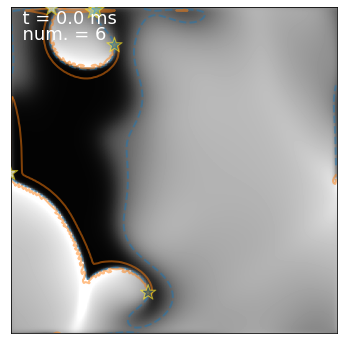

In [9]:
# dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)
x_values=np.array(dict_tips['x'])
y_values=np.array(dict_tips['y'])
c_values=np.array(dict_tips['pid'])/5
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=18,vmin_img=-85.,avmax_img=35.,area=25,
                 frameno=frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])
ax=fig.get_axes()[0]
ax.scatter(x=(0,.1),y=(0,.1),s=4000)

In [19]:
from lib.viewer.DomainPlot import SaveTipsAndColoredContours
save_folder=f"{nb_dir}/Figures/mov"
frameno=SaveTipsAndColoredContours(img,frameno,dict_tips,save_folder=save_folder)
#append the pid values to the list of pid values
#for each of their fields
#append the field value to the list of field values
!pwd

/Users/timothytyree/Documents/GitHub/care/notebooks/Figures/mov


In [20]:
# #the list of lesser contours runnning over the apparent particles
# xy_values_lst=dict_tips['lesser_xy_values']
# c_values_lst =dict_tips['lesser_curvature_values']
get_comp_tips

#for each pid,
#DONE: extract the segments from xy_values
#DONE: (segment xy_values,c_values) remove segments/partition at segments for pbc edge cases
#for each segment, plot the segments colored by local curvature

<function lib.measure.comp_tips_safely.get_comp_tips(width, height, V_threshold)>

In [14]:
#DONEDONT: print curvature for activation/deactivation fronts using dict_tips
#TODO: copy multicolored line example!
#TODO: color ^that contour by curvature!
# dict_tips['pid']
# split_contour_into_contiguous

In [15]:
#TODO: make pdict initiate correctly for arbitrary input
#TODO: make ^that run for a few more times... updating pdict, which initiates corrrectly for arbitrary input
# dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)

In [13]:
plotColoredContour

<function lib.viewer.multicolored_lines.plotColoredContour(fig, ax, xy_values_lst, c_values_lst, cmap='hot', use_colorbar=False, vmin=0.0, vmax=3.0, lw=3, navg=20, alpha=1.0)>

In [62]:
# def ShowTipsAndColoredContours(fig,ax,dict_tips,
#                            fontsize=18,cmap='hot',
#                           annotating=True,textcolor='white',
#                           vmin_tips=-np.pi/4.,vmax_tips=np.pi/4.):
#     xy_values_lst=dict_tips['greater_xy_values']
#     c_values_lst =dict_tips['greater_curvature_values']
#     plotColoredContour(fig,ax,xy_values_lst,c_values_lst,
#                           cmap='hot',use_colorbar=False,
#                        vmin=0.,vmax=3.,lw=3,navg=40,alpha=0.05)
#     #plot the list of lesser contours
#     xy_values_lst=dict_tips['lesser_xy_values']
#     c_values_lst =dict_tips['lesser_curvature_values']
#     plotColoredContour(fig,ax,xy_values_lst,c_values_lst,
#                           cmap='hot',use_colorbar=False,
#                        vmin=0.,vmax=3.,lw=3,alpha=0.5)


#     #plot spiral tips. color inner spiral tip by slow variable
#     x_values=np.array(dict_tips['x'])
#     y_values=np.array(dict_tips['y'])
#     c_values=np.array(dict_tips['phi'])
#     n_tips = x_values.shape[0]
#     ax.scatter(x=x_values, y=y_values, s=300, c=1+0.*c_values, marker='*', zorder=3, alpha=.5, vmin=0.,vmax=1.)
#     ax.scatter(x=x_values, y=y_values, s=100, c=c_values, marker='*', 
#                zorder=3, alpha=.8, vmin=vmin_tips,vmax=vmax_tips, cmap='bwr')

#     ax.set_xlim([0,width])
#     ax.set_ylim([0,height])
#     ax.axis('off')

#     if annotating:
#         time_step_string=f"  t = {t:.1f} ms"
#         message_string=f"  num. = {n_tips}"
#         ax.text(.97,.13,time_step_string,
#                 horizontalalignment='right',color=textcolor,fontsize=fontsize,
#                 transform=ax.transAxes)
#         ax.text(.97,.05,message_string,
#                 horizontalalignment='right',color=textcolor,fontsize=fontsize,
#                 transform=ax.transAxes)
#     return None

# #plot system with colored curvature
# def SaveTipsAndColoredContours(frameno,dict_tips,save_folder=None,save_fn=None,vmin_img=-85.,vmax_img=35.,inch=5):
#     save=True
#     figsize=(inch,inch)
#     fig, ax = plt.subplots(figsize=figsize)#, sharex=True, sharey=True)
#     ax.imshow(img,vmin=vmin_img,vmax=vmax_img,cmap='gray')
#     ShowTipsAndColoredContours(fig,ax,dict_tips,
#                                fontsize=18,cmap='hot',
#                               annotating=True,textcolor='white',
#                               vmin_tips=-np.pi/4.,vmax_tips=np.pi/4.)
#     if not save:
#         plt.show()
#     else:
#         if save_fn is None:
#             save_fn = f"img{frameno:07d}.png"
#             frameno += 1
#     #         plt.tight_layout()
#         if save_folder is not None:
#             os.chdir(save_folder)
#         plt.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#         plt.close();
#     return frameno

In [ ]:
# def compute_phi_values(dict_tips):
#     '''compute phase angle using lesser contour
#     Example Usage:
#     phi_lst=compute_phi_values(dict_tips)
#     dict_tips['phi']=phi_lst
#     '''
#     pid_pair_list=list(zip(dict_tips['pid'],dict_tips['lesser_pid']))
#     phi_lst=[]
#     for item in pid_pair_list:
#         pid,pid_mate=item
#         xy1_value=np.array((dict_tips['x'][pid],dict_tips['y'][pid]))
#         xy2_value=np.array((dict_tips['x'][pid_mate],dict_tips['y'][pid_mate]))
#         xy_values_activation_front=dict_tips['lesser_xy_values'][pid]
#         phi1,phi2=compute_phases_between_kernel(xy1_value,xy2_value,xy_values_activation_front)
#         phi_lst.append(phi1)
#     return phi_lst

# def compute_phases_between_kernel(xy1_value,xy2_value,xy_values_activation_front):
#     '''computes the phases between particle 1 and particle 2 in units of radians.
#     returns range between particles in units of pixels
#     #TODO(later, to scale method): convert all subtraction operations to explicitely enforce pbc...
#     # print(t_values[i])
#     '''
#     # compute displacement unit vector from tip 1 to tip 2
#     xy2_minus_xy1_value=xy2_value-xy1_value
#     range_value=np.linalg.norm(xy2_minus_xy1_value)#, axis=1)
#     x2_minus_x1_hat_value=xy2_minus_xy1_value[0]/range_value
#     y2_minus_y1_hat_value=xy2_minus_xy1_value[1]/range_value
#     xy2_minus_xy1_hat_value=np.array((x2_minus_x1_hat_value,y2_minus_y1_hat_value))
# #     xy2_minus_xy1_hat_value=np.array(list(zip(x2_minus_x1_hat_value,y2_minus_y1_hat_value)))
#     #compute the angles made with the activation front
#     xy_values=xy_values_activation_front
#     dx1dx2_hat=xy2_minus_xy1_hat_value
#     #compute a1_hat and a2_hat
#     a1=xy_values[1]-xy_values[0]
#     # xy_values[2]-xy_values[1]
#     # xy_values[3]-xy_values[2]
#     # xy_values[4]-xy_values[3]
#     a1_hat=a1/np.linalg.norm(a1)
#     a2=xy_values[-2]-xy_values[-1]
#     a2_hat=a2/np.linalg.norm(a2)
#     phi1=np.arcsin(np.cross(dx1dx2_hat,a1))
#     phi2=np.arcsin(np.cross(-1.*dx1dx2_hat,a2))
#     return phi1,phi2